In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-04-01'

In [3]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


In [41]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    
    # polytomy degree as simple branching metric
    for node in tree.tree.traverse():
        node.add_feature("log10_polytomy_degree", np.log10(len(node.children) + node.abundance))
    
    if mouse in ("7", "8"):
        print(f"skipping 10-week {mouse_gc}")
        continue
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "GC"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])

    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    df.loc[row, "total abundance"] = sum(abundances)
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)

    df.loc[row, "max LBI"] = np.nanmax([node.LBI for node in tree.tree.traverse()])    
    df.loc[row, "max LBR"] = np.nanmax([node.LBR for node in tree.tree.traverse()])

    df.loc[row, "max polytomy degree"] = np.nanmax([10 ** node.log10_polytomy_degree for node in tree.tree.traverse()])

    # note: additive delta_bind for now
    delta_bind_dat = []
    for node in tree.tree.traverse():
        if not np.isnan(node.delta_bind):
            for _ in range(node.abundance):
                delta_bind_dat.append(node.delta_bind)
    df.loc[row, "95th percentile delta_bind"] = np.percentile(delta_bind_dat, 95)
    df.loc[row, "median delta_bind"] = np.nanmedian(delta_bind_dat)

    max_lbi_idx = np.nanargmax([node.LBR for node in tree.tree.traverse()])
    df.loc[row, "delta_bind of max LBI node"] = [node.delta_bind for node in tree.tree.traverse()][max_lbi_idx]
    
df

skipping 10-week mouse7_GC90
skipping 10-week mouse7_GC91
skipping 10-week mouse7_GC92
skipping 10-week mouse7_GC93
skipping 10-week mouse8_GC84
skipping 10-week mouse8_GC85
skipping 10-week mouse8_GC86
skipping 10-week mouse8_GC87
skipping 10-week mouse8_GC88
skipping 10-week mouse8_GC89


,mouse,GC,total abundance,normalized dominance score,max LBI,max LBR,max polytomy degree,95th percentile delta_bind,median delta_bind,delta_bind of max LBI node
0,1,1,89.0,0.932584,18.789397,4.572412,17.0,1.260416,1.124685,1.16671
1,1,2,72.0,0.958333,22.944806,10.325907,16.0,1.450151,0.427885,0.36112
2,1,3,84.0,0.833333,15.535093,11.257937,28.0,1.277015,0.907880,1.20081
3,1,4,75.0,0.626667,24.779330,3.565568,18.0,1.654111,0.823810,0.86025
4,1,5,84.0,0.785714,29.827268,6.591931,24.0,1.381599,0.506470,-0.67113
...,...,...,...,...,...,...,...,...,...,...
62,5,83,78.0,0.441558,23.506305,2.350931,21.0,1.196820,0.115775,1.19682
63,6,74,78.0,0.884615,23.935277,9.933529,24.0,1.395440,0.557385,1.20747
64,6,75,70.0,0.971429,25.611653,4.754441,14.0,1.171988,0.282890,0.33100
65,6,76,81.0,0.592593,17.765943,8.617168,16.0,1.077752,0.321495,0.68784


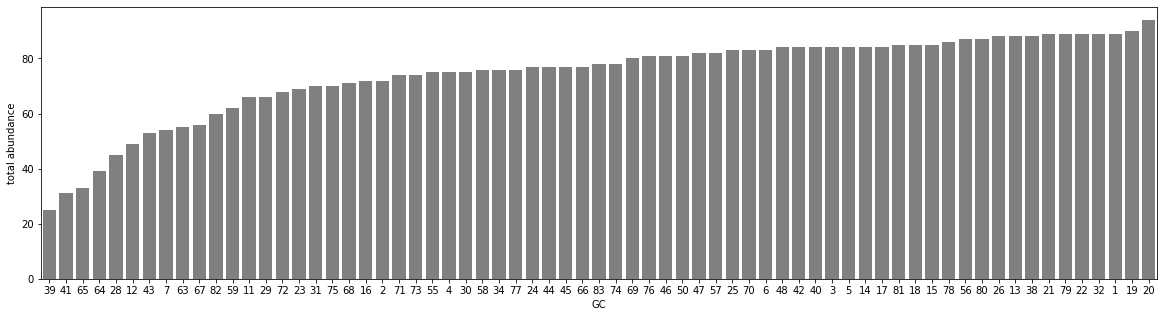

In [7]:
plt.figure(figsize=(20, 5))
sns.barplot(data=df.sort_values("total abundance"), x="GC", y="total abundance", color="grey")
plt.show()

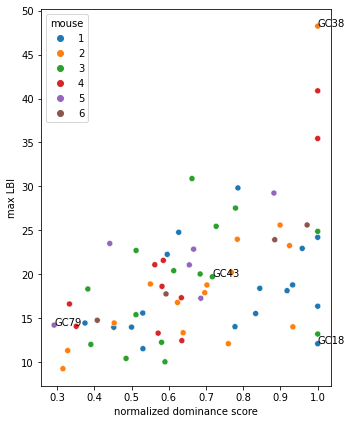

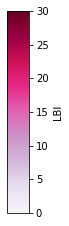

In [10]:
cmap = "PuRd"
vmin = 0
vmax = 30

fig = plt.figure(figsize=(5, 6))
sns.scatterplot(data=df, x="normalized dominance score", y="max LBI", hue="mouse", clip_on=False)
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "max LBI"]]
    if (x == 1 and (y > 45 or y < 13)) or x < 0.3 or ((.7 < x < .75) and (19 < y < 21)):
        plt.annotate(f"GC{row.GC}", [x, y])
        key = f"mouse{row.mouse}_GC{row.GC}"
        colormap = trees[key].feature_colormap("LBI", vmin=vmin, vmax=vmax, cmap=cmap)
        trees[key].render(f"output/plots/NDS_LBI.{key}.svg", colormap=colormap, scale=20, branch_margin=-8)
plt.tight_layout()
plt.savefig("output/plots/NDS_LBI.pdf")
plt.show()

fig = plt.figure()
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), cax=cax, label="LBI")
plt.savefig("output/plots/NDS_LBI.cbar.pdf")
plt.show()

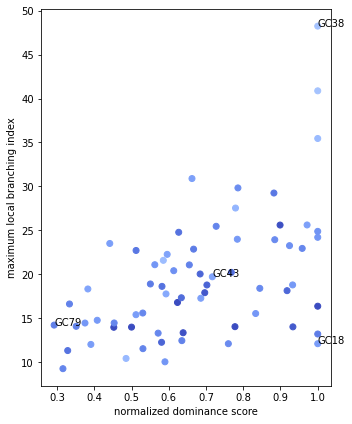

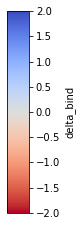

In [21]:
cmap = "coolwarm_r"
vmin = -2
vmax = 2

fig = plt.figure(figsize=(5, 6))
plt.scatter(x=df["normalized dominance score"], y=df["max LBI"],
                c=df["95th percentile delta_bind"],
#                 c=df["median delta_bind"],
#                 c=df["delta_bind of max LBI node"],
                cmap="coolwarm_r", vmin=vmin, vmax=vmax, clip_on=False)
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "max LBI"]]
    if (x == 1 and (y > 45 or y < 13)) or x < 0.3 or ((.7 < x < .75) and (19 < y < 21)):
        plt.annotate(f"GC{row.GC}", [x, y])
        key = f"mouse{row.mouse}_GC{row.GC}"
        colormap = trees[key].feature_colormap("delta_bind", vmin=vmin, vmax=vmax, cmap=cmap)
        trees[key].render(f"output/plots/NDS_LBI.{key}.binding.svg", colormap=colormap, scale=20, branch_margin=-8)

plt.xlabel("normalized dominance score")
plt.ylabel("maximum local branching index")
plt.tight_layout()
plt.savefig("output/plots/NDS_LBI.binding.pdf")
plt.show()

fig = plt.figure()
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), cax=cax, label="delta_bind")
plt.savefig("output/plots/NDS_LBI.cbar.binding.pdf")
plt.show()

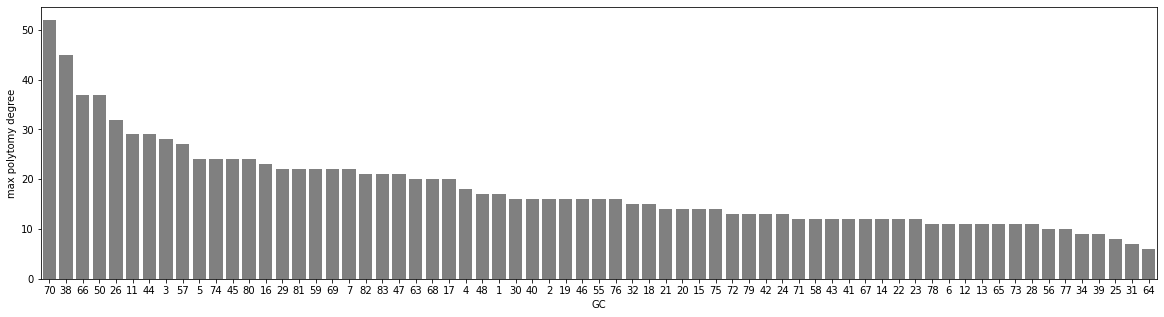

In [43]:
plt.figure(figsize=(20, 5))
sns.barplot(data=df.sort_values("max polytomy degree", ascending=False), x="GC", y="max polytomy degree", color="grey")
plt.savefig("output/plots/NDS_LBI.polytomy_degree_barplot.pdf")
plt.show()

In [45]:
vmin=0
vmax=2
cmap="plasma"

for key, tree in trees.items():
    if "GC70" in key or "GC17" in key or "GC64" in key:
        colormap = tree.feature_colormap("log10_polytomy_degree", vmin=vmin, vmax=vmax, cmap=cmap)
        tree.render(f"output/plots/NDS_LBI.{key}.polytomy_degree.svg", colormap=colormap, scale=20, branch_margin=-8)

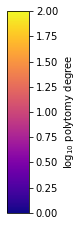

In [44]:
fig = plt.figure()
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), cax=cax, label=r"$\log_{10}$ polytomy degree")
plt.savefig("output/plots/NDS_LBI.cbar.polytomy_degree.pdf")
plt.show()